# Multi-Layer Perceptron (Neural Network)
## Research Question: "Predict whether a stop and search will conclude in police action".

#### In this notebook we attempt to answer the research question using the data set (https://www.kaggle.com/sohier/london-police-records?select=london-stop-and-search.csv), and a Multilayer Perceptron.

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, Adadelta, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.utils import to_categorical

from os.path import exists
import util_smote as usm
import util

#SMOTE
from imblearn.over_sampling import SMOTE


In [59]:
# A function that takes in a model and trains it
def train_nn(model, path, X_train, y_train, eras=1, epochs=100, min_delta=0.0001, min_lr=0.0000001, stoping_patience=4, lr_patience=2):
    #One-Hot-encode y_train
    y_encoded = to_categorical(y_train)
    #Early Stopping callback- from ex7Part1 (lab 7 of Intro to AI module)
    early_stopping = EarlyStopping(monitor='loss', min_delta=min_delta, patience=stoping_patience, verbose=1)
    #Reduce learning rate callbck - from https://keras.io/api/callbacks/reduce_lr_on_plateau/ 
    reduce_learning_rate = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=lr_patience, min_lr=min_lr, verbose=1)
    for i in range(eras):
        print(f"Starting era {i}...")
        if exists(path):
            print("🚨 Model alredy exists!")
            print("Loading model...")
            del model
            model = load_model(path)
        model.fit(X_train, y_encoded, epochs=epochs, callbacks=[reduce_learning_rate, early_stopping])
        model.save(path)

# A function that takes in a model and evaluates it
def evaluate_nn(model, path, X_test, y_test):
    del model
    model = load_model(path)
    pred = model.predict(X_test)
    pred = np.argmax(pred, axis=1)
    y_encoded = to_categorical(y_test)
    y_comparison = np.argmax(y_encoded, axis=1) 
    accuracy = metrics.accuracy_score(y_comparison, pred)
    precision = metrics.precision_score(y_comparison, pred, average="weighted")
    print(f"\nAccuracy is {accuracy * 100}")
    print(f"\nPrecision is {precision * 100}")
    #Confusion Matrix
    util.confusion_plot(y_test=y_comparison, y_predictions=pred)


## Cleaning the Data

In [45]:
data = pd.read_csv("data.csv")
data = util.data_cleaner(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165651 entries, 0 to 302621
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   Type                       165651 non-null  object             
 1   Date                       165651 non-null  datetime64[ns, UTC]
 2   Latitude                   165651 non-null  float64            
 3   Longitude                  165651 non-null  float64            
 4   Gender                     165651 non-null  object             
 5   Age range                  165651 non-null  object             
 6   Officer-defined ethnicity  165651 non-null  object             
 7   Legislation                165651 non-null  object             
 8   Object of search           165651 non-null  object             
 9   Outcome                    165651 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(2), object(7)
memory 

## Encoding Data

In [46]:
data_encoded, encoders = util.data_encoder(data)
outcome_classes = encoders["Outcome Encoder"].classes_
data_encoded.head()

,Type,Date,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,Outcome
0,1,0,51.512286,-0.114491,1,1,0,4,8,6
1,1,0,51.512286,-0.114491,1,1,0,4,8,6
2,1,1,51.512286,-0.114491,1,1,4,4,8,6
4,0,2,51.512286,-0.114491,1,1,4,4,8,6
5,1,3,51.512286,-0.114491,1,1,0,3,3,2


## Splitting the Data

In [47]:
#Splt into X and y, while one-hot-encoding the target

target = data_encoded["Outcome"]
features = data_encoded.drop('Outcome', axis=1)

# Split into features and target
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=10)

## The MLP

We start with a basic MLP:
- Input
- Hidden (9 unit, relu activation)
- Output (8 unit, softmax)

### Build

In [48]:
simple_model = Sequential()
simple_model.add(Dense(9, input_dim=9, activation='relu'))
simple_model.add(Dense(8, activation='softmax'))
simple_model.compile(loss='categorical_crossentropy', optimizer='adam')

### Train

In [51]:
%%time

model_name = "simple(9_9_8)"
path = f"./models/{model_name}.h5"

train_nn(simple_model, path=path, X_train=X_train, y_train=y_train, eras=1, epochs=100, min_delta=0.00001, min_lr=0.0000001, stoping_patience=4, lr_patience=2)

Starting era 0...
🚨 Model alredy exists!
Loading model...
Epoch 1/100
4142/4142 [==============================] - 2s 441us/step - loss: 1.0166
Epoch 2/100
4142/4142 [==============================] - 2s 442us/step - loss: 1.0165
Epoch 3/100
4074/4142 [============================>.] - ETA: 0s - loss: 1.0173
Epoch 00003: ReduceLROnPlateau reducing learning rate to 1e-07.
4142/4142 [==============================] - 2s 444us/step - loss: 1.0166
Epoch 4/100
4142/4142 [==============================] - 2s 438us/step - loss: 1.0166
Epoch 5/100
4137/4142 [============================>.] - ETA: 0s - loss: 1.0166
Epoch 00005: ReduceLROnPlateau reducing learning rate to 1e-07.
4142/4142 [==============================] - 2s 437us/step - loss: 1.0166
Epoch 6/100
4142/4142 [==============================] - 2s 433us/step - loss: 1.0166
Epoch 00006: early stopping
CPU times: user 16.6 s, sys: 3.32 s, total: 19.9 s
Wall time: 11.1 s


### Evaluate


Accuracy is 63.260994235006486

Precision is 48.81364240790211


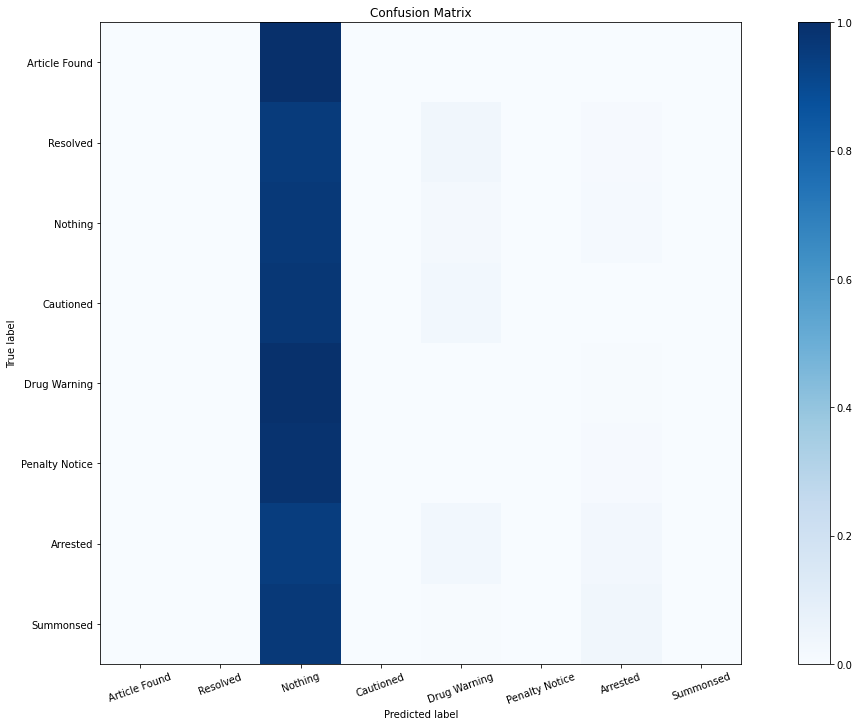

In [34]:
evaluate_nn(model=simple_model, path=path, X_test=X_test, y_test=y_test)

The model was able to predict test set 63% of the time. It is highly biased to predict class 2 ("Nothing found - no further action"), suggesting an underfit of the data.

## Adding More Hidden Layers

We try to add more layers to alleviate the underfitting of our model

### Build

In [35]:
model_more_hidden = Sequential()
model_more_hidden.add(Dense(9, input_dim=9, activation='relu')) # Hidden 1
model_more_hidden.add(Dense(9, activation='relu')) # Hidden 2
model_more_hidden.add(Dense(9, activation='relu')) # Hidden 3
model_more_hidden.add(Dense(8, activation='softmax')) # Ouput
model_more_hidden.compile(loss='categorical_crossentropy', optimizer='adam')

### Train

In [36]:
%%time

model_name = "simple(9_9_9_9_8)"
path = f"./models/{model_name}.h5"

train_nn(model_more_hidden, path=path, X_train=X_train, y_train=y_train, eras=1, epochs=100, min_delta=0.00001, min_lr=0.0000001, stoping_patience=4, lr_patience=2)

Starting era 0...
Epoch 1/100
4142/4142 [==============================] - 2s 531us/step - loss: 28.5880
Epoch 2/100
4142/4142 [==============================] - 2s 533us/step - loss: 1.0043
Epoch 3/100
4142/4142 [==============================] - 2s 534us/step - loss: 1.0040
Epoch 4/100
4142/4142 [==============================] - 2s 523us/step - loss: 1.0104
Epoch 5/100
4065/4142 [============================>.] - ETA: 0s - loss: 1.0039
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
4142/4142 [==============================] - 2s 521us/step - loss: 1.0042
Epoch 6/100
4142/4142 [==============================] - 2s 515us/step - loss: 1.0039
Epoch 7/100
4142/4142 [==============================] - 2s 524us/step - loss: 1.0038
Epoch 8/100
4128/4142 [============================>.] - ETA: 0s - loss: 1.0036
Epoch 00008: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
4142/4142 [==============================] - 2s 524us/step - loss: 1.


Accuracy is 65.1021701729498

Precision is 42.38292561227715


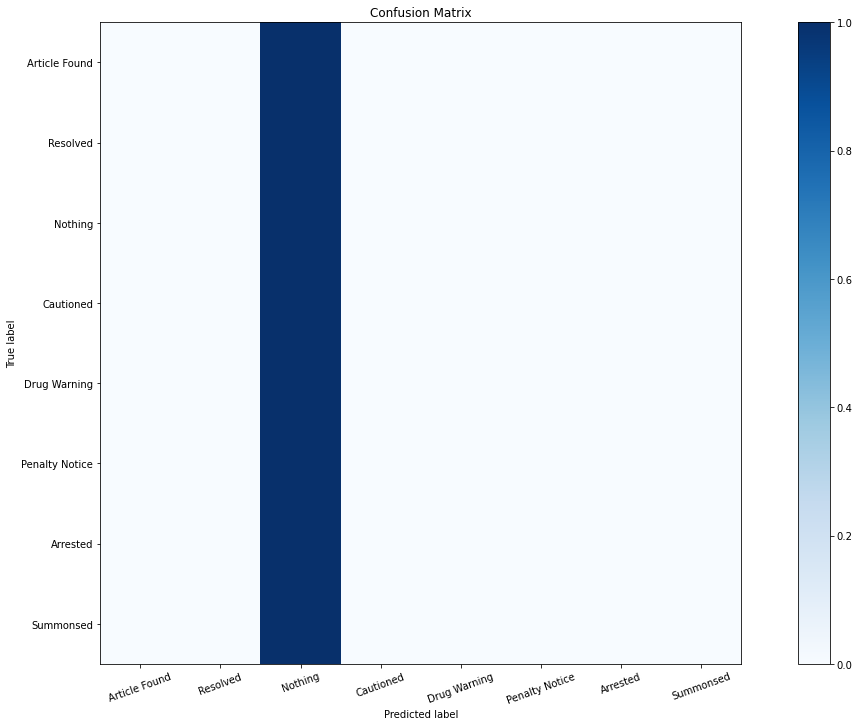

In [60]:
evaluate_nn(model=model_more_hidden, path=path, X_test=X_test, y_test=y_test)

Accuracy not signficantly improved... however, precision has increased.

# Sigmoid Activation

Let's try using sigmid instead of relu as our activation

### Build

In [39]:
sigmoid_model = Sequential()
sigmoid_model.add(Dense(9, input_dim=9, activation='sigmoid')) # Hidden 1
sigmoid_model.add(Dense(9, activation='sigmoid')) # Hidden 2
sigmoid_model.add(Dense(9, activation='sigmoid')) # Hidden 3
sigmoid_model.add(Dense(8, activation='softmax')) # Ouput
sigmoid_model.compile(loss='categorical_crossentropy', optimizer='adam')

### Train

In [40]:
%%time

model_name = "sigmoid(9_9_9_9_8)"
path = f"./models/{model_name}.h5"

train_nn(sigmoid_model, path=path, X_train=X_train, y_train=y_train, eras=1, epochs=100, min_delta=0.00001, min_lr=0.0000001, stoping_patience=4, lr_patience=2)

Starting era 0...
Epoch 1/100
4142/4142 [==============================] - 2s 534us/step - loss: 1.0268
Epoch 2/100
4142/4142 [==============================] - 2s 540us/step - loss: 1.0046
Epoch 3/100
4142/4142 [==============================] - 2s 529us/step - loss: 1.0045
Epoch 4/100
4142/4142 [==============================] - 2s 521us/step - loss: 1.0045
Epoch 5/100
4047/4142 [============================>.] - ETA: 0s - loss: 1.0046
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
4142/4142 [==============================] - 2s 521us/step - loss: 1.0045
Epoch 6/100
4142/4142 [==============================] - 2s 524us/step - loss: 1.0040
Epoch 7/100
4142/4142 [==============================] - 2s 538us/step - loss: 1.0040
Epoch 8/100
4098/4142 [============================>.] - ETA: 0s - loss: 1.0044
Epoch 00008: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
4142/4142 [==============================] - 2s 540us/step - loss: 1.0

### Evaluate


Accuracy is 65.1021701729498

Precision is 42.38292561227715


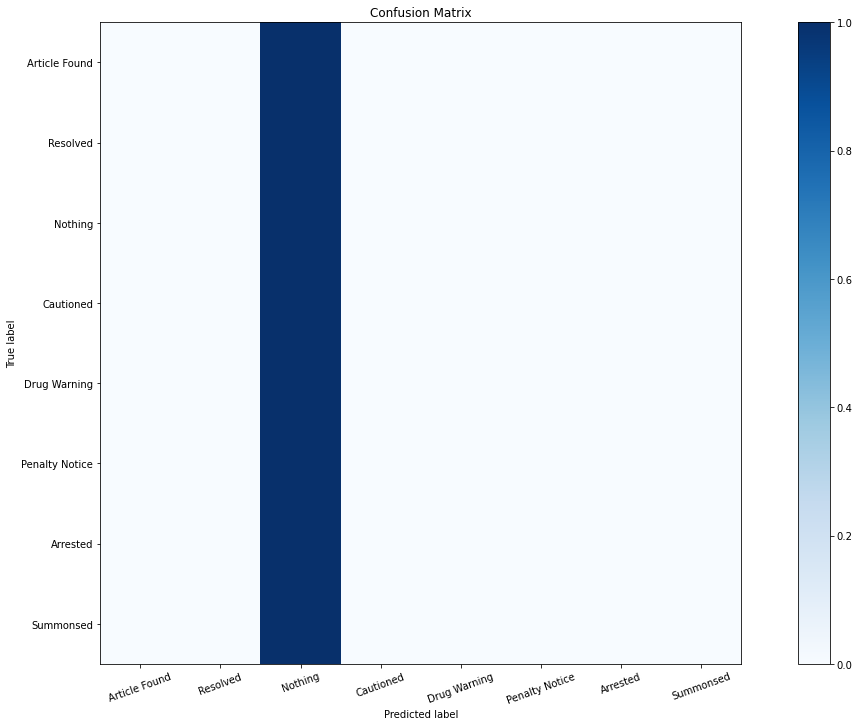

In [41]:
evaluate_nn(model=sigmoid_model, path=path, X_test=X_test, y_test=y_test)

Results worse. Relu is the superior activation function for that architecture.

# Using SMOTE 

The issue seems to be that a single class dominates the other classes by far in terms of frequency.

Class 0: 0.02%     (41)
Class 1: 0.68%     (1121)
Class 2: 65.41%     (108353)
Class 3: 0.1%     (167)
Class 4: 10.74%     (17788)
Class 5: 2.31%     (3824)
Class 6: 19.96%     (33067)
Class 7: 0.78%     (1290)
Total: 165651


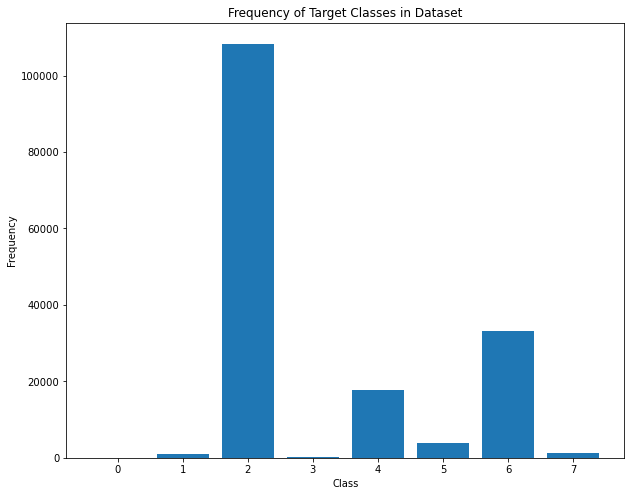

In [12]:
#The frequencies of each class in the dataset
usm.display_frequencies(data_encoded["Outcome"])

65% of the example targets belong to class 2! 

We can solve this by using SMOTE to generate artificial data for our minor classes.

### Preprocessing

Class 0: 12.5%     (86784)
Class 1: 12.5%     (86784)
Class 2: 12.5%     (86784)
Class 3: 12.5%     (86784)
Class 4: 12.5%     (86784)
Class 5: 12.5%     (86784)
Class 6: 12.5%     (86784)
Class 7: 12.5%     (86784)
Total: 694272


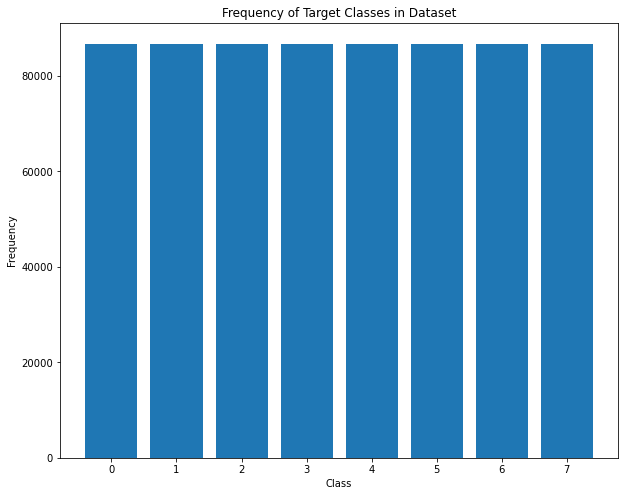

In [53]:
X_smote, y_smote = usm.smote_data(X_train, y_train)
y_encoded = to_categorical(y_smote)
usm.display_frequencies(y_smote)


After using SMOTE, the frequencies of each class have been equalized.

We can begin training now...

### Build Model

In [70]:
smote_model = Sequential()
smote_model.add(Dense(9, input_dim=9, activation='relu')) # Hidden 1
smote_model.add(Dense(9, activation='relu')) # Hidden 2
smote_model.add(Dense(9, activation='relu')) # Hidden 3
smote_model.add(Dense(8, activation='softmax')) # Ouput
smote_model.compile(loss='categorical_crossentropy', optimizer='adam')

### Train

In [71]:
%%time
model_name = "smoted(9_9_9_9_8)"
path = f"./models/{model_name}.h5"

train_nn(smote_model, path=path, X_train=X_smote, y_train=y_smote, eras=1, epochs=100, min_delta=0.00001, min_lr=0.0000001, stoping_patience=4, lr_patience=2)


Starting era 0...
Epoch 1/100
21696/21696 [==============================] - 11s 521us/step - loss: 3.2208
Epoch 2/100
21696/21696 [==============================] - 11s 521us/step - loss: 2.0771
Epoch 3/100
21696/21696 [==============================] - 11s 527us/step - loss: 2.0770
Epoch 4/100
21696/21696 [==============================] - 12s 531us/step - loss: 2.0919
Epoch 5/100
21625/21696 [============================>.] - ETA: 0s - loss: 2.0805
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
21696/21696 [==============================] - 11s 527us/step - loss: 2.0805
Epoch 6/100
21696/21696 [==============================] - 11s 523us/step - loss: 2.0757
Epoch 7/100
21696/21696 [==============================] - 11s 525us/step - loss: 2.0749
Epoch 8/100
21696/21696 [==============================] - 11s 522us/step - loss: 2.0748
Epoch 9/100
21696/21696 [==============================] - 11s 521us/step - loss: 2.0747
Epoch 10/100
21607/21696 [====

### Evaluate


Accuracy is 0.13884277564818448

Precision is 4.084708241365207


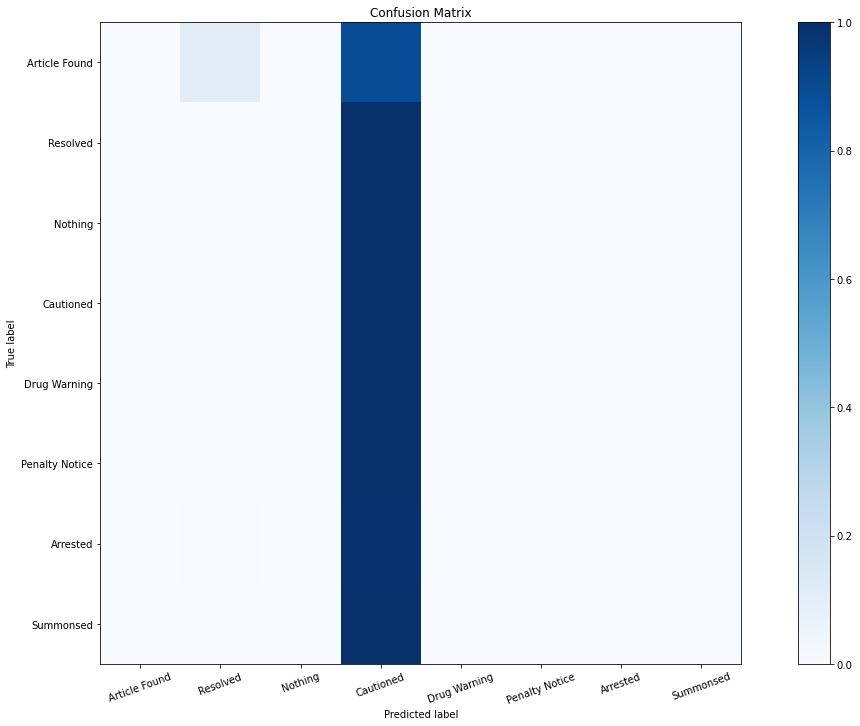

In [72]:
evaluate_nn(model=smote_model, path=path, X_test=X_test, y_test=y_test)

Accuracy is obviously much worse, but the model is not blindly selecting the majority class anymore. Given the increased size of the data (added aritifical data), we try a large network.

## SMOTE (Playground)

Find a tabulation of all tested models, and their confusion matrices, inside: 
- src/models/Models tested.pages 
- src/models/Confusion Matrix

In [114]:
smote_model = Sequential()

smote_model.add(Dense(60, input_dim=9, activation='relu'))
smote_model.add(Dropout(0.04))
for i in range(20):
    smote_model.add(Dense(60, activation='relu'))
smote_model.add(Dense(8, activation='softmax'))
smote_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [116]:
%%time
model_name = "dropout_model(60_dropout(0.04)_60x20_8)"
path = f"./models/{model_name}.h5"

train_nn(smote_model, path=path, X_train=X_smote, y_train=y_smote, eras=1, epochs=95, min_delta=0.0001, min_lr=1e-10, stoping_patience=4, lr_patience=2)

Starting era 0...
Epoch 1/95
21696/21696 [==============================] - 30s 1ms/step - loss: 1.9200
Epoch 2/95
21696/21696 [==============================] - 30s 1ms/step - loss: 1.8837
Epoch 3/95
21696/21696 [==============================] - 31s 1ms/step - loss: 1.8756
Epoch 4/95
21696/21696 [==============================] - 30s 1ms/step - loss: 1.8723
Epoch 5/95
21696/21696 [==============================] - 33s 2ms/step - loss: 1.8662
Epoch 6/95
21696/21696 [==============================] - 33s 2ms/step - loss: 1.8663
Epoch 7/95
21696/21696 [==============================] - 33s 2ms/step - loss: 1.8641
Epoch 8/95
21696/21696 [==============================] - 36s 2ms/step - loss: 1.8683
Epoch 9/95
21685/21696 [============================>.] - ETA: 0s - loss: 1.8641
Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
21696/21696 [==============================] - 36s 2ms/step - loss: 1.8641
Epoch 10/95
21696/21696 [==============================] 


Accuracy is 4.470133711629591

Precision is 50.180796870294685


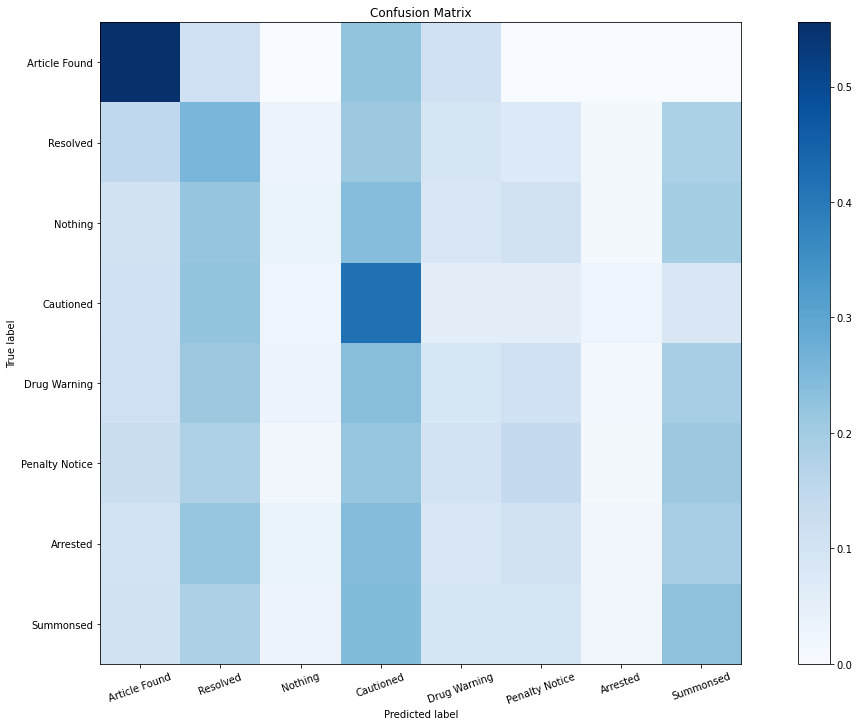

In [118]:
evaluate_nn(model=smote_model, path=path, X_test=X_test, y_test=y_test)

# SMOTE (With Bias to Class 2)

Matrix for SMOTE is better. However, it the score is signficantly worse- all of the models tested happened to be biased against predicting "Nothing", and the "Nothing" class accounts for 65% of the target.

We therefore try SMOTE again, but instead of equalizing all classes, we increase the frequency of the minor classes, while maintaining the dominance of class 2.

### Pre Processing

Class 0: 0.02%     (32)
Class 1: 0.67%     (891)
Class 2: 65.49%     (86784)
Class 3: 0.1%     (131)
Class 4: 10.74%     (14229)
Class 5: 2.27%     (3014)
Class 6: 19.95%     (26436)
Class 7: 0.76%     (1003)
Total: 132520


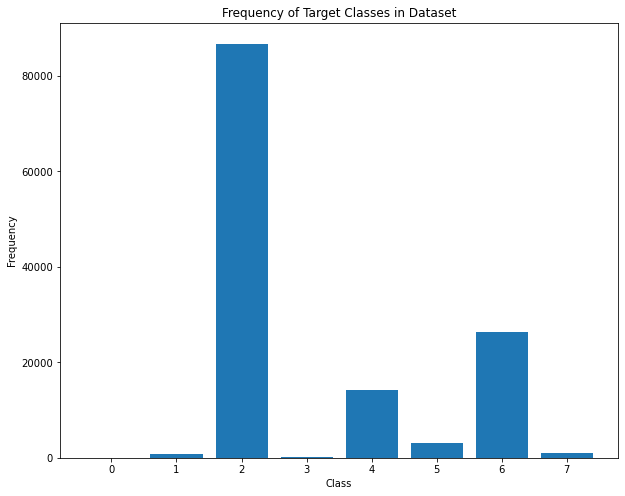

In [22]:
#Train/test split data_encoded
target = data_encoded["Outcome"]
features = data_encoded.drop('Outcome', axis=1)
X_train3, X_test3, y_train3, y_test3 = train_test_split(features, target, test_size=0.2, random_state=10)

#Before Smote
usm.display_frequencies(y_train3)

Class 0: 7.76%     (30000)
Class 1: 7.76%     (30000)
Class 2: 22.44%     (86784)
Class 3: 7.76%     (30000)
Class 4: 15.51%     (60000)
Class 5: 12.93%     (50000)
Class 6: 18.1%     (70000)
Class 7: 7.76%     (30000)
Total: 386784


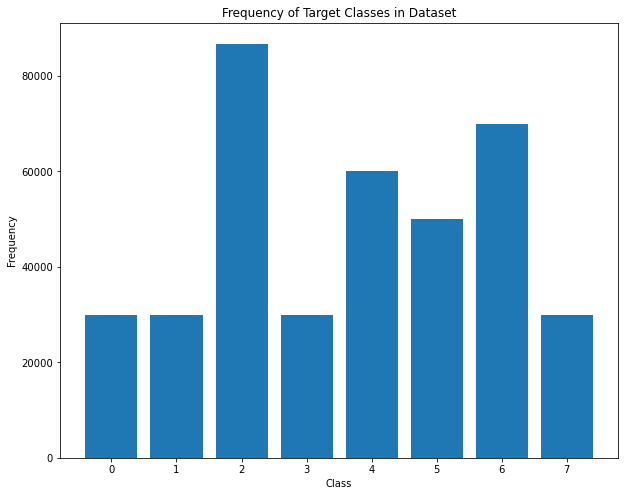

In [24]:
sampling_strategy = {0:30000, 1:30000, 2:86784, 3:30000, 4:60000, 5:50000, 6:70000, 7:30000}
X_smote, y_smote = usm.smote_data(X_train3, y_train3, sampling_strategy=sampling_strategy)

usm.display_frequencies(y_smote)

### Build model

In [46]:
#Train MLP
model = Sequential()

model_name = "model(9_1000x5_8)_biased_smote_16_batch"
path = f"./models/{model_name}.h5"

model.add(Dense(1000, input_dim=9, activation='relu'))
for i in range(4):
    model.add(Dense(1000, activation='relu'))

model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train

In [47]:
%%time

# min_lr = 0.0000001
# batch_size = 10

min_lr = 0.00001
batch_size = 16

#Early Stopping callback- from ex7Part1 (lab 7 of Intro to AI module)
earlyStopping = EarlyStopping(monitor='loss', min_delta=0.00001, patience=4, verbose=1)

#Reduce learning ratr callbck - from https://keras.io/api/callbacks/reduce_lr_on_plateau/ 
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, min_lr=min_lr, verbose=1)

for i in range(2):
    print(f"Starting era {i}...")
    if exists(path):
        print("Loading model...")
        del model
        model = load_model(path)
    model.fit(X_s, y_hot, epochs=5, batch_size=batch_size, callbacks=[reduce_lr, earlyStopping])
    model.save(path)

Starting era 0...
Epoch 1/5
 6045/43392 [===>..........................] - ETA: 7:30 - loss: 10.2253 - accuracy: 0.1234

KeyboardInterrupt: 

### Evaluate


Score is 1.7415713380217923


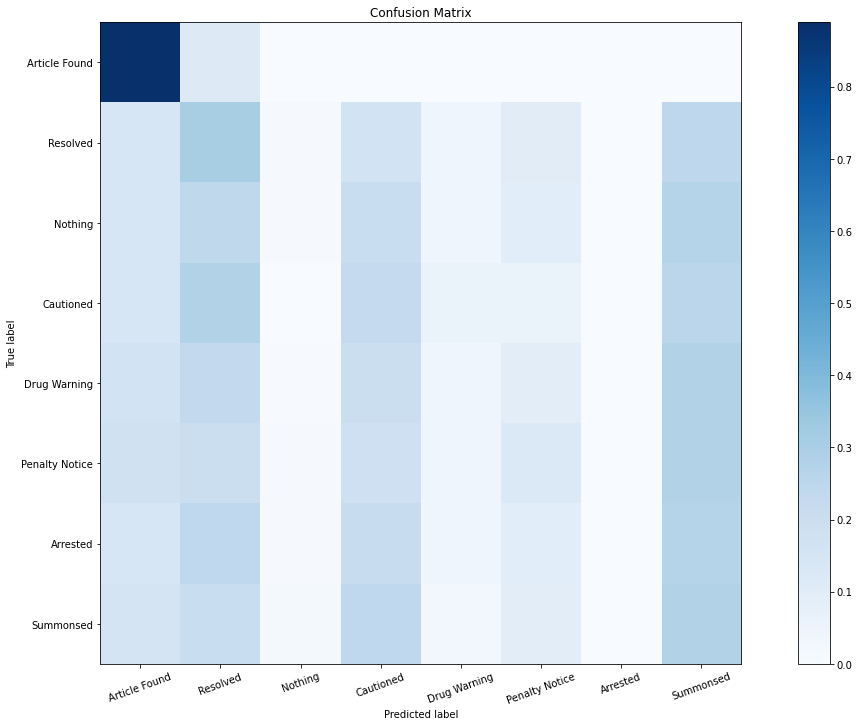

In [45]:
del model
model = load_model(path)

pred = model.predict(X_test2)
pred = np.argmax(pred, axis=1)
# print(f"Prediction\n{pred[:1000]}")
y_test_hot = to_categorical(y_test2)
y_compare = np.argmax(y_test_hot, axis=1) 
# print(f"Y test\n{y_compare[:1000]}")
score = metrics.accuracy_score(y_compare, pred)
print(f"\nScore is {score * 100}")

#Confusion Matrix
util.confusion_plot(y_test=y_compare, y_predictions=pred)